In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [5]:
Nba_combined = pd.read_csv('../data/processed/NbaCombined.csv')
Nba_combined = Nba_combined.drop(columns="Unnamed: 0")


### Distribution of Win Shares

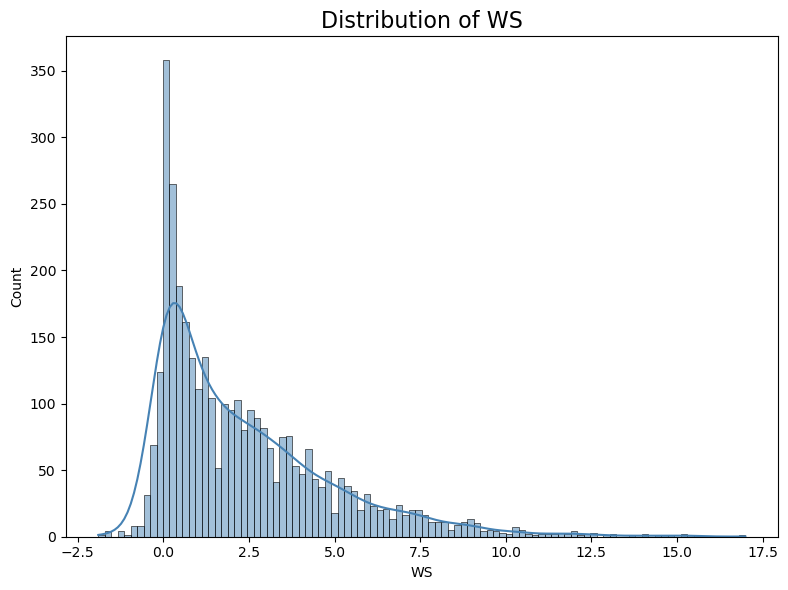

In [6]:
# List of target variables to plot
targets = ['WS']

# Loop through each target and plot its histogram
for column in targets:
    plt.figure(figsize=(8, 6))
    sns.histplot(Nba_combined[column], kde=True, bins=100, color='steelblue')  # Histogram + KDE curve
    plt.title(f'Distribution of {column}', fontsize=16)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

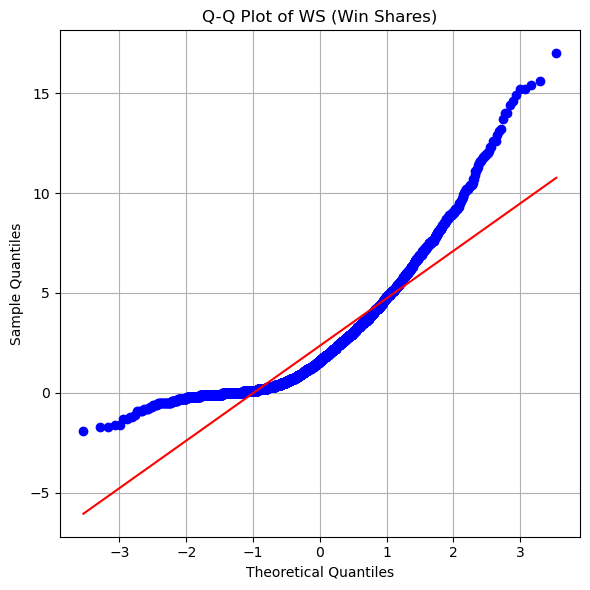

In [7]:
ws_data = Nba_combined['WS'].dropna()

plt.figure(figsize=(6, 6))
stats.probplot(ws_data, dist="norm", plot=plt)  
plt.title('Q-Q Plot of WS (Win Shares)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
print(Nba_combined['WS'].min())

-1.9


for log transformations the minimum value has to be greater than 0, so we will need to shift the data by 1 on where the minimum value is.

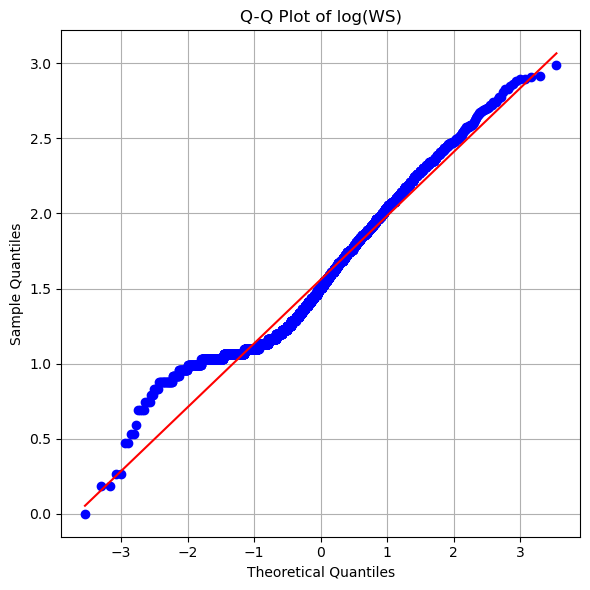

In [9]:
min_ws = Nba_combined['WS'].min()
shift = 1 - min_ws if min_ws <= 0 else 0
Nba_combined['log_WS'] = np.log(Nba_combined['WS'] + shift)


wsplot2 = Nba_combined
plt.figure(figsize=(6, 6))
stats.probplot(Nba_combined['log_WS'].dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot of log(WS)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.tight_layout()
plt.show()

The date seems more normal than before after log transformation.

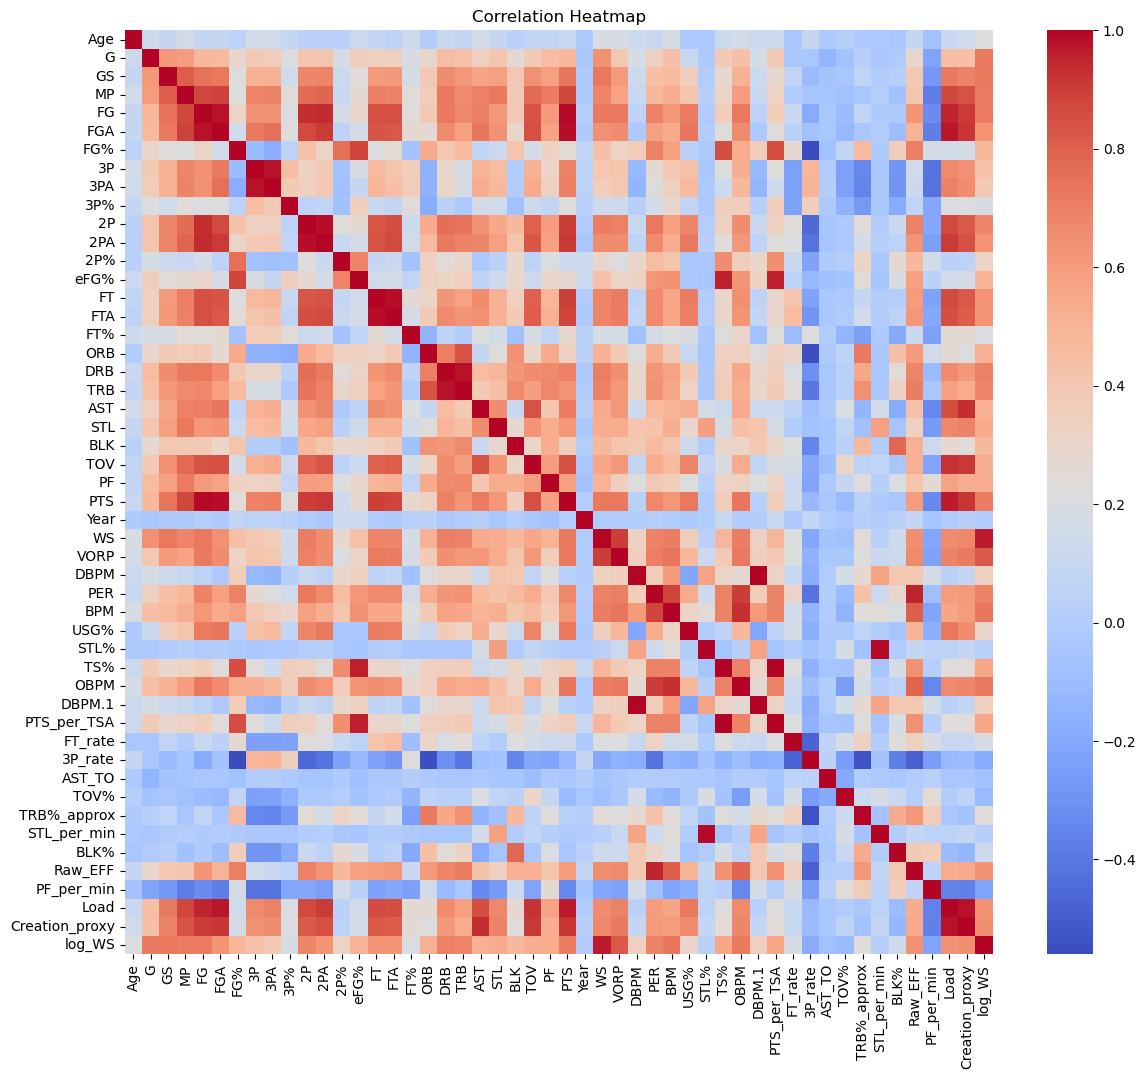

In [10]:
correlation_matrix = Nba_combined.corr(numeric_only=True)   
# Create a heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

lets check win shares of each variable and win share of each variable

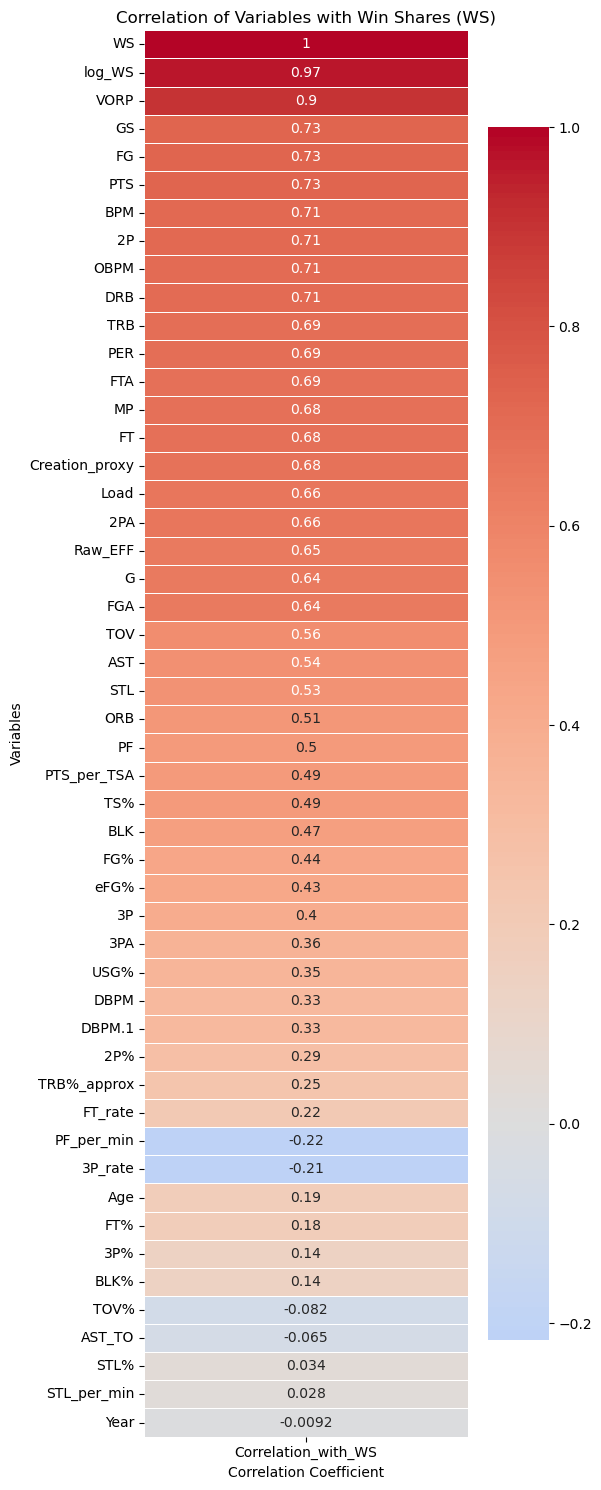

In [11]:
# Calculate correlation matrix of the entire DataFrame

# Extract correlations with 'WS' column and convert to DataFrame
ws_corr_df = correlation_matrix['WS'].to_frame(name='Correlation_with_WS')

# Optional: Sort by absolute correlation descending
ws_corr_df = ws_corr_df.reindex(ws_corr_df['Correlation_with_WS'].abs().sort_values(ascending=False).index)

# Plot vertical heatmap
plt.figure(figsize=(6, len(ws_corr_df) * 0.3))  # adjust height for readability
sns.heatmap(ws_corr_df, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation of Variables with Win Shares (WS)')
plt.ylabel('Variables')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

Looking at the heatmap it looks like the most correlated features are:
- VORP
- BPM, DBPM, OBPM (Box Plus Minus)
- 2P (2 point percentage)
- DRB, TRB (Defensive and Total Rebounds)
- PER (Player Efficiency Rating)
- FTA, FT
- Creation_proxy (Player creation proxy)
- Load 
- MP
- FG, FGA
- G, GS (Games and Games Started)
- Raw EFF (Raw Efficiency)


This will be good to use for Both Models of XGBoost and Simple Linear Regression. Now, lets check for multicollinearity between the possible features

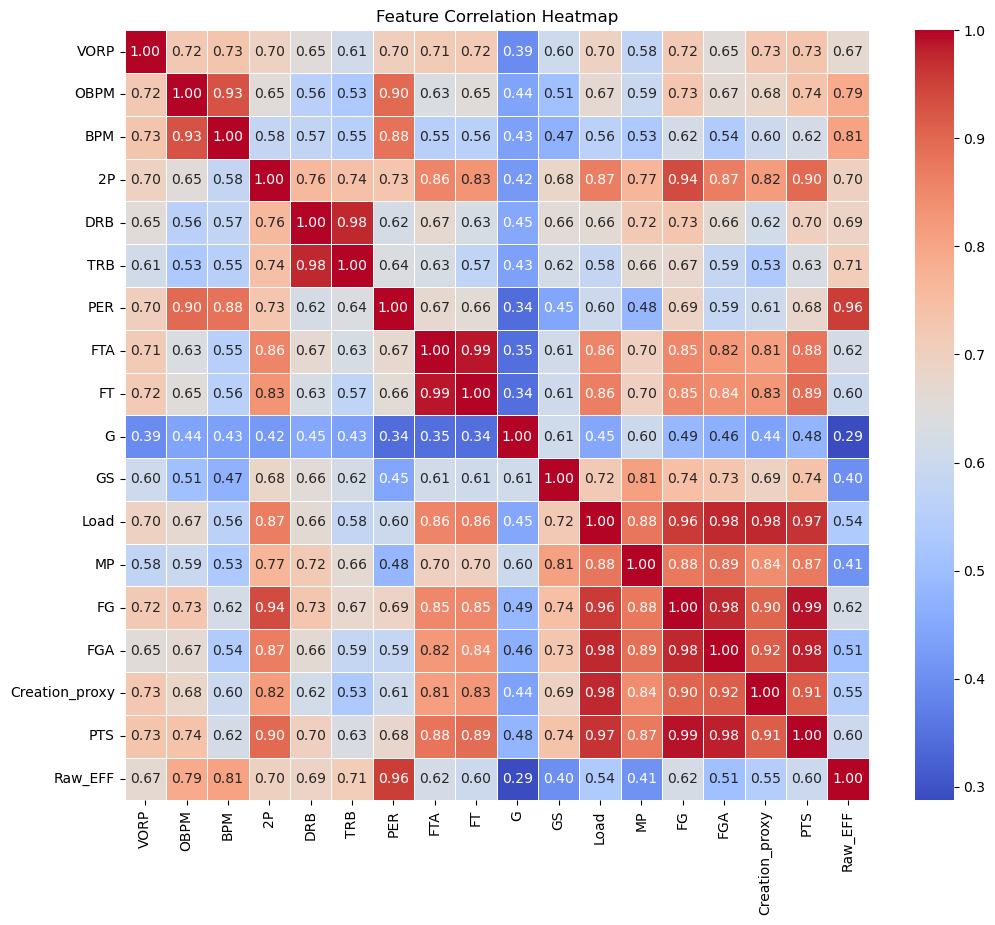

In [12]:
FeatureCorr = Nba_combined[['VORP','OBPM', 'BPM','2P','DRB','TRB','PER', 'FTA', 'FT','G','GS','Load', 'MP', 'FG', 'FGA', 'Creation_proxy','PTS', 'Raw_EFF']]
# Compute the correlation matrix
corr_matrix = FeatureCorr.corr()

# Set the figure size and plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

From Looking at this heatmap of the correlation of the features, we can see that there is multicollinearity between the features. This is because the features are highly correlated with each other. So lets drop a few highly correlated features. Lets list them out: 
1. FG, FGA, Load and Creation Proxy, These 4 features are highly correlated with each other. So We will drop 3 of features and keep one for now. Since FG is the highly correlated feature of win shares, we will keep it.
2. TRB and DRB, Since DRB is highly correlated with TRB, we will drop TRB.
3. FT and FTA are highly correlated, we will drop FT. 
4. Raw Efficiency and PER are highly correlated, we will drop Raw Efficiency.

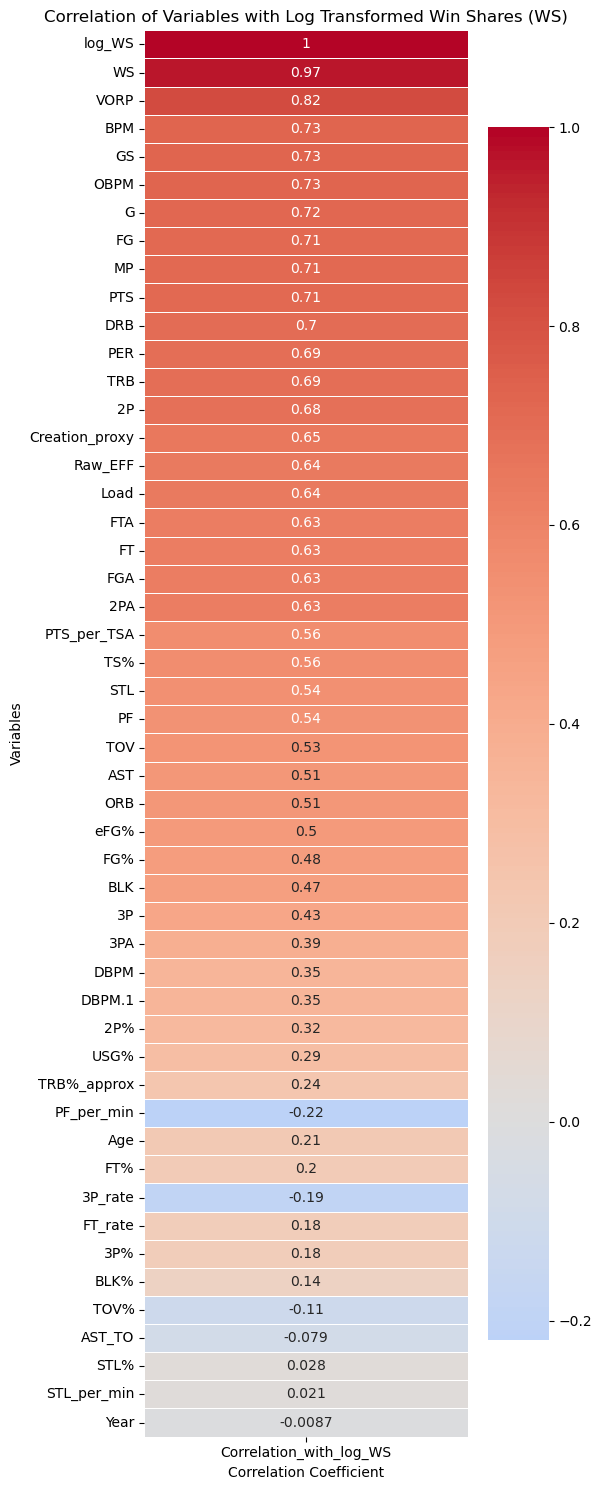

In [13]:
#Check correlations of log_ws

# Calculate correlation matrix of the entire DataFrame

# Extract correlations with 'WS' column and convert to DataFrame
ws_corr_df = correlation_matrix['log_WS'].to_frame(name='Correlation_with_log_WS')

# Optional: Sort by absolute correlation descending
ws_corr_df = ws_corr_df.reindex(ws_corr_df['Correlation_with_log_WS'].abs().sort_values(ascending=False).index)

# Plot vertical heatmap
plt.figure(figsize=(6, len(ws_corr_df) * 0.3))  # adjust height for readability
sns.heatmap(ws_corr_df, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation of Variables with Log Transformed Win Shares (WS)')
plt.ylabel('Variables')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

for this we can use the following features:
- VORP
- FG
- TRB
- PER
- FTA
- MP
- GS
- PTS
- G 
- Year (for time series)

In [14]:
Nba_combined.to_csv('nba_combined.csv')

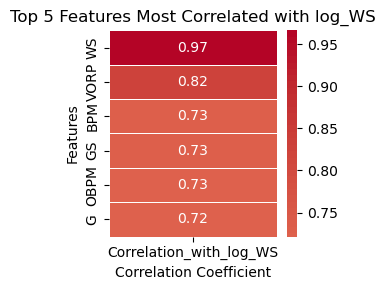

In [23]:
# Step 1: Compute correlation matrix
correlation_matrix = Nba_combined.corr(numeric_only=True)  # Use your DataFrame name

# Step 2: Extract correlations with log_WS
ws_corr_df = correlation_matrix['log_WS'].drop('log_WS')  # Remove self-correlation

# Step 3: Sort by absolute value and take top 5
top_features = ws_corr_df.reindex(ws_corr_df.abs().sort_values(ascending=False).index).head(6)

# Step 4: Convert to DataFrame for heatmap
top_features_df = top_features.to_frame(name='Correlation_with_log_WS')

# Step 5: Plot vertical heatmap
plt.figure(figsize=(3, 3))  # Adjust height based on number of features
sns.heatmap(top_features_df, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Top 5 Features Most Correlated with log_WS')
plt.ylabel('Features')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()
